# Remarks of the author

1. This code works as a skeleton, so that users can exploit it and define their own implementations. This means that the users should **NOT** expect to run solely this piece of code to get the figures of our paper https://doi.org/10.1109/TCOMM.2024.3461569.

2. To specify the utility and cost functions, the users that are interested have 3 options:
    1. define their own functions/emulators, 
    2. use our (limited) dataset https://github.com/jaayala/power_dlul_dataset,
    3. send email to [m.kalntis@tudelft.nl](mailto:m.kalntis@tudelft.nl) for more information.

3. If you use any piece of the code here, please check *README.md* for citing.

# 1. Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# For reproducability
np.random.seed(5)

# 2. Functions to emulate testbed

In [2]:
class EmulationFunctions:
    """Class for utility, power cost, and reward calculation.
    
    Parameters
    ----------
    delta: float
        prioritizes utility or power cost function.
    """
    
    def __init__(self, delta: float) -> None:
        self.delta = delta

    def f_utility(self, s_t: tuple, cd_t: tuple) -> float:
        """Dummy utility function."""
        return sum(s_t) * np.random.random() + sum(cd_t) * np.random.random()

    def f_power(self, s_t: tuple, cd_t: tuple) -> float:
        """Dummy power cost function."""
        return sum(s_t) * np.random.random() + sum(cd_t) * np.random.random()

    def f_reward(self, s_t: tuple, cd_t: tuple) -> float:
        """Calculate the reward based on utility and power cost defined above."""
        utility = self.f_utility(s_t, cd_t)
        power = self.f_power(s_t, cd_t)
        return utility - self.delta * power

# 3. Configuration and Environment classes

In [3]:
class Configuration:
    """Class to define and handle system configurations.
    
    Parameters
    ----------
    p_dl: list
        maximum allowed vBS transmission power control in DL
    
    m_dl: list
        highest eligible MCS in DL
    
    m_ul: list
        maximum vBS transmission airtime in DL
    
    a_ul: list
        highest eligible MCS in UL
    
    m_ul: list
        maximum vBS transmission airtime in UL
    """

    def __init__(self, p_dl: list[float], m_dl: list[float], a_dl: list[float], m_ul: list[float], a_ul: list[float]) -> None:
        self.p_dl = p_dl
        self.m_dl = m_dl
        self.a_dl = a_dl
        self.m_ul = m_ul
        self.a_ul = a_ul

    def generate_configurations(self) -> list:
        """ Generate a dictionary with all possible combinations of the parameters"""
        return list(itertools.product(self.p_dl, self.m_dl, self.a_dl, self.m_ul, self.a_ul))

In [4]:
class Environment:
    """Class to generate the environment, i.e., channels conditions and traffic demands
    
    Parameters
    ----------
    c_dl: int
        Channel Quality Indicator (CQI) in DL
    
    c_ul: int
        CQI in UL
    
    d_dl: float
        traffic demands in DL
        
    d_ul: float
        traffic demands in UL
        
    T: int
        time horizon (total number of slots)
    """
    
    def __init__(self, c_dl: int, c_ul: int, d_dl: float, d_ul: float, T: int) -> None:
        self.c_dl = c_dl
        self.c_ul = c_ul
        self.d_dl = d_dl
        self.d_ul = d_ul
        self.T = T
    
    def generate_environment(self) -> list:
        return [(c_dl[t], c_ul[t], d_dl[t], d_ul[t]) for t in range(self.T)]
        

# 4. BSvBS algorithm

In [5]:
class BSvBSAlgorithm:
    """Class implementing the BSvBS algorithm
    
    Parameters
    ----------
    T: int
        time horizon (total number of slots)
        
    S: int
        number of configurations/arms
        
    delta: float
        prioritizes utility or power cost function.
    
    config_dict: dict
        dictionary, with key: number of arm (configuration) and 
        values (p_dl, m_dl, a_dl, a_ul, m_ul)
        
    cd_arr: list
        channel conditions and traffic demands
    
    reward_min: float, optional (default=-16)
        minimum reward value used to scale the rewards in [0, 1]
    
    reward_max: float, optional (default=-10)
        maximum reward value used to scale the rewards in [0, 1]
    """

    def __init__(self, T: int, S: int, delta: float, config_dict: dict[int, tuple], cd_arr: list, reward_min: float = -16, reward_max: float = -10) -> None:
        self.T = T
        self.S = S
        self.delta = delta
        self.config_dict = config_dict
        self.cd_arr = cd_arr
        self.reward_min = reward_min
        self.reward_max = reward_max
        # used in the algorithm to balance exploration and exploitation
        self.gamma = min(1, np.sqrt(self.S * np.log(self.S) / ((np.exp(1) - 1) * self.T)))
        # reward/payoff of the selected arm/configuration chosen at every timestep
        self.reward_chosen = np.zeros(self.T)
        # probabilities of each configuration
        self.y = np.ones(self.S)
        # emulation functions
        self.emulation_func = EmulationFunctions(self.delta)
        

    @staticmethod
    def draw_arm(probs: list[float]) -> int:
        """Draw arms/configurations from a multinomial distribution, based on the probabilities assigned to each arm."""
        arms = np.random.multinomial(1, probs)
        return np.nonzero(arms)[0][0]

    
    def run(self, t: int, feedback: bool) -> np.ndarray:
        """Run BSvBS algorithm and return the reward of the chosen configurations and the environment at every timeslot"""
        # update distribution
        logit_map = [(1.0 - self.gamma) * y_a / np.sum(self.y) + self.gamma / self.S for y_a in self.y]
        x_t = logit_map
        # sample next configuration based on probability distribution
        s_t_num = self.draw_arm(x_t)
        s_t = self.config_dict[s_t_num]
        # observe network conditions and user demands;
        # careful: these are not known in advance, even though the implentation here just reads them from cd_arr
        observe_cd = cd_arr[t]
        # receive and scale reward in [0, 1]
        reward = self.emulation_func.f_reward(s_t, observe_cd)
        reward = max(min(reward, self.reward_max), self.reward_min)
        reward_scaled = (reward - self.reward_min) / (self.reward_max - self.reward_min)
        # allow or block feedback of this algorithm, according to MetBS
        if feedback or t == 0:
            # calculate weighted feedback
            u_estimate = np.zeros(self.S)
            u_estimate[s_t_num] = reward_scaled / x_t[s_t_num]
            # update the weights
            self.y[s_t_num] = self.y[s_t_num] * np.exp(u_estimate[s_t_num] * self.gamma / self.S)
        # save rewards
        self.reward_chosen[t] = reward_scaled
        return self.reward_chosen[t]

# 5. MetBS

In [6]:
class MetBSAlgorithm:
    """Class implementing MetBS algorithm

    Parameters
    ----------
    N: int
        number of times to run the simulation
    
    T: int
        time horizon (total number of slots)
        
    S: int
        number of configurations/arms
    
    h: float
        prioritizes exploration of more algorithms or exploitation of the best-performing ones
    
    alg_nams: list
        list containing a string to discern each algorithm (e.g., their name)
        
    alg_objs: list
        list of algorithms to choose from, e.g., BSvBSAlgorithm(...)
    """
    def __init__(self, N: int, T: int, S: int, h: float, alg_nams: list, alg_objs: list):
        self.N = N
        self.T = T
        self.S = S
        self.h = h
        self.alg_nams = alg_nams
        self.alg_objs = alg_objs
        self.alg_num = len(alg_objs) # total number of algorithm instances
        # for keeping track of the choices
        self.this_round_reward = np.zeros((self.N, self.T), dtype=object)
        self.alg_cnt_chosen_allow_feedback = np.zeros((self.N, self.alg_num))
        
        
    @staticmethod
    def draw_arm(probs: list[float]) -> int:
        """Draw arms/configurations from a multinomial distribution, based on the probabilities assigned to each arm."""
        arms = np.random.multinomial(1, probs)
        return np.nonzero(arms)[0][0]

    
    def run(self) -> tuple[np.ndarray, np.ndarray]:
        """Run MetBS algorithm."""
        for n in range(self.N):
            w = np.ones(self.alg_num) # weight of each algorithm
            for t in range(self.T):
                # update distribution
                prob = [(1.0 - self.h) * w_j / np.sum(w) + self.h / self.alg_num for w_j in w]
                # select algorithm based on probability distribution
                alg_chosen_ind = self.draw_arm(prob)
                alg_chosen_obj = self.alg_objs[alg_chosen_ind]
                alg_chosen_nam = self.alg_nams[alg_chosen_ind]
                # feedback control
                p = h / (self.alg_num * prob[alg_chosen_ind])
                bool_allow_feedback = np.random.binomial(n=1, p=p, size=1)[0]
                # run only the chosen algo, which will learn if bool_allow_feedback==1
                reward_algo = alg_chosen_obj.run(t=t, feedback=bool_allow_feedback)
                # estimated reward
                reward_estimate = np.zeros(self.alg_num)
                reward_estimate[alg_chosen_ind] = reward_algo / prob[alg_chosen_ind]
                # score update
                w[alg_chosen_ind] *= np.exp(reward_estimate[alg_chosen_ind] * self.h / self.alg_num)
                # save reward and count algorithm selections
                self.this_round_reward[n, t] = (reward_algo, alg_chosen_nam)
                if bool_allow_feedback:
                    self.alg_cnt_chosen_allow_feedback[n, alg_chosen_ind] += 1
                    
        return self.this_round_reward, self.alg_cnt_chosen_allow_feedback
    
    
    
    

# 6. Define setup and show results

In [7]:
# configuration setup
p_dl = [70]
m_dl = [0, 5, 16, 27]
a_dl = [0, 0.2, 0.6, 1]
m_ul = [0, 5, 14, 23]
a_ul = [0.01, 0.4, 0.6, 1]
config_dict = {indx: ele for indx, ele in enumerate(Configuration(p_dl, m_dl, a_dl, m_ul, a_ul).generate_configurations())}


# parameters
T = 50000
S = len(config_dict)
N = 10


# environment (channel conditions and traffic demands)
c_dl = np.random.randint(12, 16, T)
c_ul = np.random.randint(12, 16, T)
d_dl = np.random.uniform(29, 32, T)
d_ul = np.random.uniform(20, 23, T)
cd_arr = Environment(c_dl, c_ul, d_dl, d_ul, T).generate_environment()


In [8]:
# all algorithms to choose from 
alg_nams = ['BSvBS_delta-1', 'BSvBS_delta-10', 'BSvBS_delta-100']
# reward_mins and reward_maxs are determined from deltas and the max/min of EmulationFunctions 
deltas = [1, 10, 100]
reward_mins = [-170, -1800, -19000]
reward_maxs = [170, 130, -30]
alg_objs = [BSvBSAlgorithm(T, S, delta, config_dict, cd_arr, reward_min, reward_max) for reward_min, reward_max, delta in zip(reward_mins, reward_maxs, deltas)]


In [9]:
h = T**(-1/3)*(len(alg_nams)**(1/3))
metbs_algorithm = MetBSAlgorithm(N, T, S, h, alg_nams, alg_objs)
this_round_reward, alg_cnt_chosen_allow_feedback = metbs_algorithm.run()

In [10]:
# make sure the same random numbers and environment are met in each round
reward_chosen_BSvBS = np.zeros((len(alg_objs), T))
for i, alg in enumerate(alg_objs):
    for t in range(T):
        # run BSvBS but allow the algorithm to learn in each round
        reward_chosen_BSvBS[i, t] = alg.run(t=t, feedback=1)
        

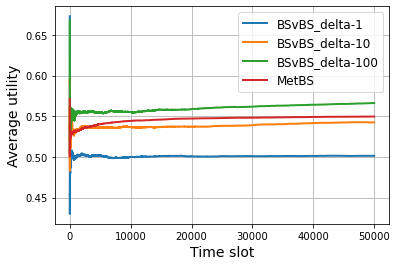

In [12]:
fig, ax = plt.subplots()
tt = np.arange(1, T+1)

alg_rews = np.array([[tup[0] for tup in array] for array in this_round_reward])
round_reward_mean = np.mean(alg_rews, axis=0)

ax.plot(((np.cumsum(reward_chosen_BSvBS[0]))/tt), label='BSvBS_delta-1', linewidth=2)
ax.plot(((np.cumsum(reward_chosen_BSvBS[1]))/tt), label='BSvBS_delta-10', linewidth=2)
ax.plot(((np.cumsum(reward_chosen_BSvBS[2]))/tt), label='BSvBS_delta-100', linewidth=2)
ax.plot(((np.cumsum(round_reward_mean))/tt)[1:], label='MetBS', linewidth=2)

ax.set_xlabel('Time slot', fontsize=14)
ax.set_ylabel('Average utility', fontsize=14)
ax.grid()
ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax.legend(fontsize=12)
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()